<a href="https://colab.research.google.com/github/rhaulmendonca/Acidentes-por-Aeronave/blob/main/Sistemas%20de%20Apoio%20%C3%A0%20Decis%C3%A3o/CENIPA_Acidentes_por_aeronave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
pip install adjustText

In [4]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.6 MB/s eta 0:00:00


In [5]:
pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [6]:
pip install gmplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.7/164.7 kB 3.1 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import datetime
import calendar
from matplotlib.ticker import PercentFormatter
import geopandas as gpd
import re
import adjustText as aT
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn import metrics
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from catboost.utils import get_confusion_matrix
from catboost import cv
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

file_path = '/content/drive/MyDrive/Colab Notebooks/Sistemas de Apoio a Decisão/126 - CENIPA - Acidentes por Aeronave.xlsx'
df = pd.read_excel(file_path)

In [ ]:
num_rows, num_cols = df.shape
print("Número de linhas:", num_rows)
print("Número de colunas:", num_cols)


Número de linhas: 10397
Número de colunas: 55


In [ ]:
import os

# Obtendo o tamanho do arquivo em KB
file_size_kb = os.path.getsize(file_path) / 1024
print("Tamanho do arquivo (KB):", file_size_kb)


Tamanho do arquivo (KB): 2525.181640625


In [ ]:
df.info()  # Exibe informações sobre cada coluna e tipo de dado


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10397 entries, 0 to 10396
Data columns (total 55 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Código da ocorrência               10397 non-null  int64         
 1   Classificação da ocorrência        10397 non-null  object        
 2   Latitude da ocorrência             10397 non-null  float64       
 3   Longitude da ocorrência            10397 non-null  float64       
 4   Código IBGE do município           10397 non-null  int64         
 5   Nome do município                  10397 non-null  object        
 6   Código IBGE da microrregião        10397 non-null  int64         
 7   Nome da microrregiao               10397 non-null  object        
 8   Código IBGE da mesoregião          10397 non-null  int64         
 9   Nome da mesoregião                 10397 non-null  object        
 10  Código IBGE da UF                 

In [ ]:
df.head()


,Código da ocorrência,Classificação da ocorrência,Latitude da ocorrência,Longitude da ocorrência,Código IBGE do município,Nome do município,Código IBGE da microrregião,Nome da microrregiao,Código IBGE da mesoregião,Nome da mesoregião,...,Categoria de registro,Segmento de registro,Aeródromo de origem,Aeródromo de destino,Fase de operação,Nível de dano da aeronave,Total de fatalidades,Tipo de ocorrência,Categoria do tipo de ocorrência,Taxonomia do tipo ICAO
0,78640,ACIDENTE,-16.762062,-49.438403,5200050,Abadia de Goiás,52010,Goiânia,5203,Centro Goiano,...,ULTRALEVE,EXPERIMENTAL,FORA DE AERODROMO,FORA DE AERODROMO,CRUZEIRO,SUBSTANCIAL,0,FALHA DO MOTOR EM VOO,FALHA OU MAU FUNCIONAMENTO DO MOTOR | FALHA DO...,SCF-PP
1,46633,ACIDENTE,-16.762062,-49.438403,5200050,Abadia de Goiás,52010,Goiânia,5203,Centro Goiano,...,AVIÃO,EXPERIMENTAL,FORA DE AERODROMO,FORA DE AERODROMO,MANOBRA,SUBSTANCIAL,0,FALHA DO MOTOR EM VOO,FALHA OU MAU FUNCIONAMENTO DO MOTOR | FALHA DO...,SCF-PP
2,80154,ACIDENTE,-1.962741,-48.196593,1500206,Acará,15012,Tomé-Açu,1504,Nordeste Paraense,...,AVIÃO,PARTICULAR,NÃO IDENTIFICADO,NÃO IDENTIFICADO,Sem Informação,LEVE,0,INDETERMINADO,INDETERMINADO,UNK
3,38855,ACIDENTE,-31.867518,-54.163801,4300034,Aceguá,43031,Campanha Meridional,4306,Sudoeste Rio-grandense,...,AVIÃO,ESPECIALIZADA,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,SUBSTANCIAL,1,PERDA DE CONTROLE EM VOO,PERDA DE CONTROLE EM VOO,LOC-I
4,50831,ACIDENTE,-17.400018,-50.379307,5200134,Acreúna,52014,Vale do Rio dos Bois,5205,Sul Goiano,...,AVIÃO,PARTICULAR,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,DESTRUÍDA,4,PERDA DE CONTROLE EM VOO,PERDA DE CONTROLE EM VOO,LOC-I


In [ ]:
df.dtypes


,0
Código da ocorrência,int64
Classificação da ocorrência,object
Latitude da ocorrência,float64
Longitude da ocorrência,float64
Código IBGE do município,int64
Nome do município,object
Código IBGE da microrregião,int64
Nome da microrregiao,object
Código IBGE da mesoregião,int64
Nome da mesoregião,object


In [ ]:
df.describe()

,Código da ocorrência,Latitude da ocorrência,Longitude da ocorrência,Código IBGE do município,Código IBGE da microrregião,Código IBGE da mesoregião,Código IBGE da UF,Código IBGE da região,Dia da ocorrência,Ano da ocorrência,Data e hora da ocorrência,Dia de divulgação da publicação,Total de recomendações,Total de aeronaves envolvidas,PMD aeronave,Categoria PMD aeronave,Quantidade de assentos,Ano de fabricação,Total de fatalidades
count,10397.000000,10397.000000,10397.000000,1.039700e+04,10397.000000,10397.000000,10397.000000,10397.000000,10397,10397.000000,10397,10397,10397.000000,10397.000000,10397.000000,10397.000000,10397.000000,10397.000000,10397.000000
mean,62441.940848,-18.392234,-48.115042,3.461259e+06,34487.253438,3452.180244,34.587670,3.127729,2016-04-27 09:13:43.737616640,2015.814947,2016-04-28 00:07:00.742041088,1929-08-19 04:23:34.100221184,0.361354,1.022891,21161.756372,21161.756372,34.723670,1857.477253,0.145619
min,28256.000000,-884.917000,-72.787966,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2007-01-01 00:00:00,2007.000000,2007-01-01 00:00:00,1900-01-02 00:00:00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46306.000000,-23.404066,-51.227035,3.106200e+06,31018.000000,3105.000000,31.000000,3.000000,2011-10-25 00:00:00,2011.000000,2011-10-25 14:40:00,1900-01-02 00:00:00,0.000000,1.000000,1270.000000,1270.000000,2.000000,1977.000000,0.000000
50%,65098.000000,-21.178000,-47.880612,3.516853e+06,35032.000000,3507.000000,35.000000,3.000000,2016-03-07 00:00:00,2016.000000,2016-03-07 14:57:00,1900-01-02 00:00:00,0.000000,1.000000,2155.000000,2155.000000,6.000000,1992.000000,0.000000
75%,80090.000000,-13.553388,-44.210987,4.204202e+06,42008.000000,4202.000000,42.000000,4.000000,2021-05-09 00:00:00,2021.000000,2021-05-09 20:00:00,2009-03-09 00:00:00,0.000000,1.000000,23000.000000,23000.000000,13.000000,2008.000000,0.000000
max,83097.000000,4.595018,0.000000,5.300108e+06,53001.000000,5301.000000,53.000000,5.000000,2023-12-31 00:00:00,2023.000000,2023-12-31 22:30:00,2023-12-29 00:00:00,83.000000,4.000000,397000.000000,397000.000000,659.000000,9999.000000,199.000000
std,17456.408952,14.369120,6.962138,1.116616e+06,11160.267604,1116.051957,10.981005,1.191398,NaN,5.234625,NaN,NaN,1.586162,0.162510,39945.063114,39945.063114,64.004453,506.471969,2.066319


In [ ]:
def get_duplicates(df):
 coluna = [column for column in df.columns if 'Código da ocorrência' in column]
 coluna = coluna[0]
 duplicados = df.loc[df[coluna].duplicated()][coluna].values
 df_duplicados = df[df[coluna].isin(duplicados)].sort_values(by=coluna)
 return df_duplicados

In [ ]:
get_duplicates(df)

,Código da ocorrência,Classificação da ocorrência,Latitude da ocorrência,Longitude da ocorrência,Código IBGE do município,Nome do município,Código IBGE da microrregião,Nome da microrregiao,Código IBGE da mesoregião,Nome da mesoregião,...,Categoria de registro,Segmento de registro,Aeródromo de origem,Aeródromo de destino,Fase de operação,Nível de dano da aeronave,Total de fatalidades,Tipo de ocorrência,Categoria do tipo de ocorrência,Taxonomia do tipo ICAO
9905,31255,ACIDENTE,-24.166843,-54.096779,4127403,Terra Roxa,41022,Toledo,4106,Oeste Paranaense,...,AVIÃO,PARTICULAR,FORA DE AERODROMO,FORA DE AERODROMO,CORRIDA APÓS POUSO,DESTRUÍDA,0,POUSO LONGO,EXCURSÃO DE PISTA | POUSO LONGO,RE
9907,31255,ACIDENTE,-24.166843,-54.096779,4127403,Terra Roxa,41022,Toledo,4106,Oeste Paranaense,...,AVIÃO,PARTICULAR,FORA DE AERODROMO,FORA DE AERODROMO,CORRIDA APÓS POUSO,DESTRUÍDA,0,PERDA DE CONTROLE NO SOLO,PERDA DE CONTROLE NO SOLO,LOC-G
2932,31875,INCIDENTE GRAVE,-15.600666,-56.097856,5103403,Cuiabá,51017,Cuiabá,5104,Centro-Sul Mato-grossense,...,AVIÃO,INSTRUÇÃO,MARECHAL RONDON,ESTÂNCIA SANTA RITA,DECOLAGEM,LEVE,0,PERDA DE CONTROLE NO SOLO,PERDA DE CONTROLE NO SOLO,LOC-G
2928,31875,INCIDENTE GRAVE,-15.600666,-56.097856,5103403,Cuiabá,51017,Cuiabá,5104,Centro-Sul Mato-grossense,...,AVIÃO,INSTRUÇÃO,MARECHAL RONDON,ESTÂNCIA SANTA RITA,DECOLAGEM,LEVE,0,EXCURSÃO DE PISTA,EXCURSÃO DE PISTA,RE
542,32916,ACIDENTE,-2.748361,-42.826727,2101707,Barreirinhas,21004,Lençóis Maranhenses,2101,Norte Maranhense,...,AVIÃO,TÁXI AÉREO,RANCHO SUMIDOR,RANCHO SUMIDOR,CORRIDA APÓS POUSO,SUBSTANCIAL,0,COLISÃO COM OBSTÁCULOS NO SOLO,COLISÃO NO SOLO | COLISÃO COM OBSTÁCULOS NO SOLO,GCOL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4612,82561,INCIDENTE GRAVE,-23.153000,-47.058000,3524006,Itupeva,35047,Jundiaí,3512,Macro Metropolitana Paulista,...,ULTRALEVE,EXPERIMENTAL,MURARO - SP,MURARO - SP,CRUZEIRO,LEVE,0,FALHA OU MAU FUNCIONAMENTO DO MOTOR,FALHA OU MAU FUNCIONAMENTO DO MOTOR,SCF-PP
8902,82600,INCIDENTE,-25.532994,-49.183860,4125506,São José dos Pinhais,41037,Curitiba,4110,Metropolitana de Curitiba,...,AVIÃO,Sem Informação,HERCÍLIO LUZ,GOVERNADOR JOSÉ RICHA,CRUZEIRO,NENHUM,0,FALHA OU MAU FUNCIONAMENTO DO MOTOR,FALHA OU MAU FUNCIONAMENTO DO MOTOR,SCF-PP
8900,82600,INCIDENTE,-25.532994,-49.183860,4125506,São José dos Pinhais,41037,Curitiba,4110,Metropolitana de Curitiba,...,AVIÃO,Sem Informação,HERCÍLIO LUZ,GOVERNADOR JOSÉ RICHA,CRUZEIRO,NENHUM,0,FOGO/FUMAÇA (SEM IMPACTO),FOGO/FUMAÇA (SEM IMPACTO),F-NI
8959,82874,ACIDENTE,-15.628746,-58.180367,5107107,São José dos Quatro Marcos,51014,Jauru,5103,Sudoeste Mato-grossense,...,AVIÃO,AGRÍCOLA,FORA DE AERODROMO,FORA DE AERODROMO,MANOBRA,SUBSTANCIAL,1,PERDA DE CONTROLE EM VOO,PERDA DE CONTROLE EM VOO,LOC-I


In [ ]:
# Contar valores faltantes por coluna
print(df.isnull().sum())

Código da ocorrência                   0
Classificação da ocorrência            0
Latitude da ocorrência                 0
Longitude da ocorrência                0
Código IBGE do município               0
Nome do município                      0
Código IBGE da microrregião            0
Nome da microrregiao                   0
Código IBGE da mesoregião              0
Nome da mesoregião                     0
Código IBGE da UF                      0
Sigla UF                               0
Unidade federativa                     0
Código IBGE da região                  0
Sigla da região                        0
Região                                 0
País da ocorrência                     0
Aeródromo da ocorrência                0
Dia da ocorrência                      0
Ano da ocorrência                      0
Hora da ocorrência                     0
Data e hora da ocorrência              0
Aeronave liberada da investigação    314
Status da investigação                 0
Número de divulg

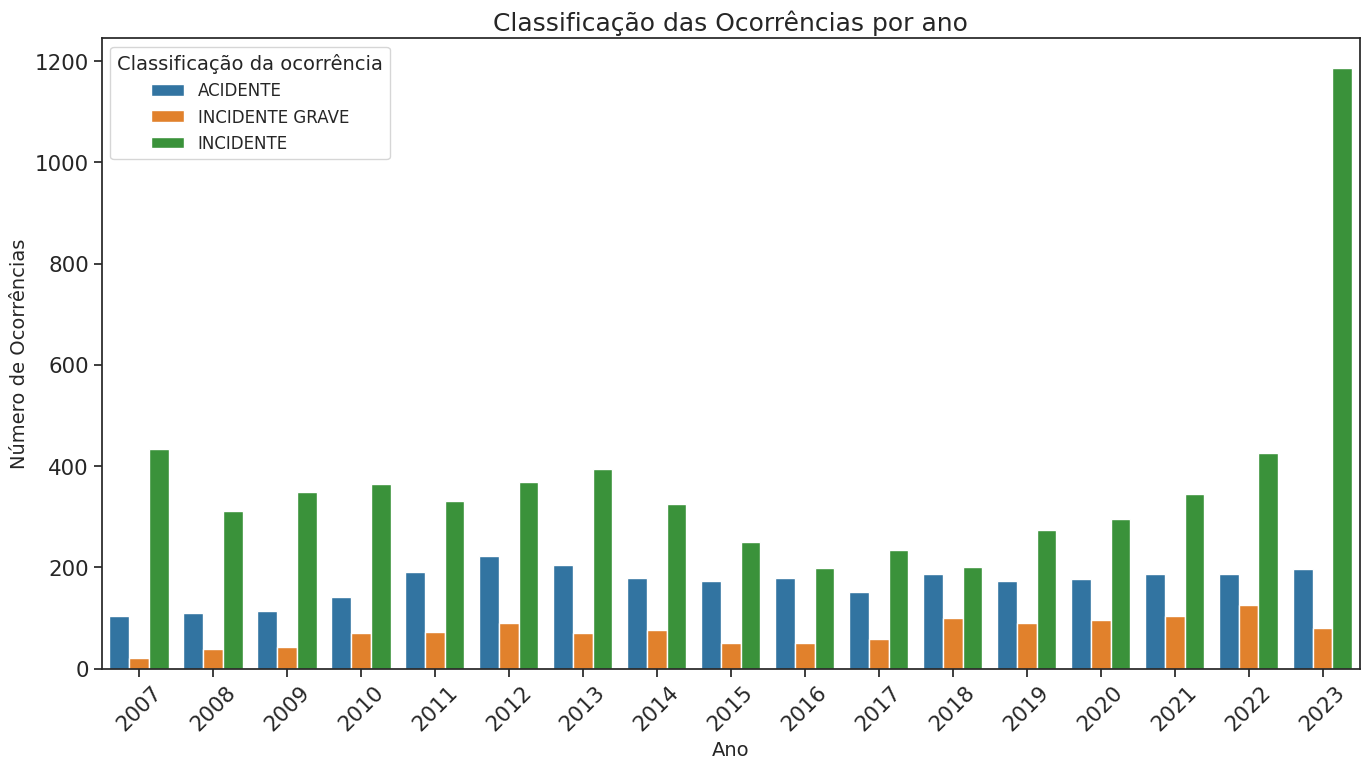

In [10]:
# Configurações do gráfico
plt.figure(figsize=(14, 8))  # Tamanho do gráfico
sbn.set(font_scale=1.4)  # Ajustar o tamanho da fonte
sbn.set_style('ticks')  # Estilo de grade

# Definir nova ordem e paleta de cores
hue_order = ['ACIDENTE', 'INCIDENTE GRAVE', 'INCIDENTE']
palette = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Cores personalizadas (azul, laranja, verde)

# Gráfico de barras
sbn.countplot(
    data=df,
    hue='Classificação da ocorrência',
    x='Ano da ocorrência',
    palette=palette,  # Paleta de cores
    hue_order=hue_order  # Ordem personalizada
)

# Personalização dos eixos e título
plt.title('Classificação das Ocorrências por ano', fontsize=18)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Número de Ocorrências', fontsize=14)
plt.legend(title='Classificação da ocorrência', title_fontsize=14, fontsize=12)
plt.xticks(rotation=45)  # Girar os rótulos do eixo X para facilitar a leitura
plt.tight_layout()  # Ajustar os espaçamentos
plt.show()


<ipython-input-11-d29b570f3ce1>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sbn.barplot(


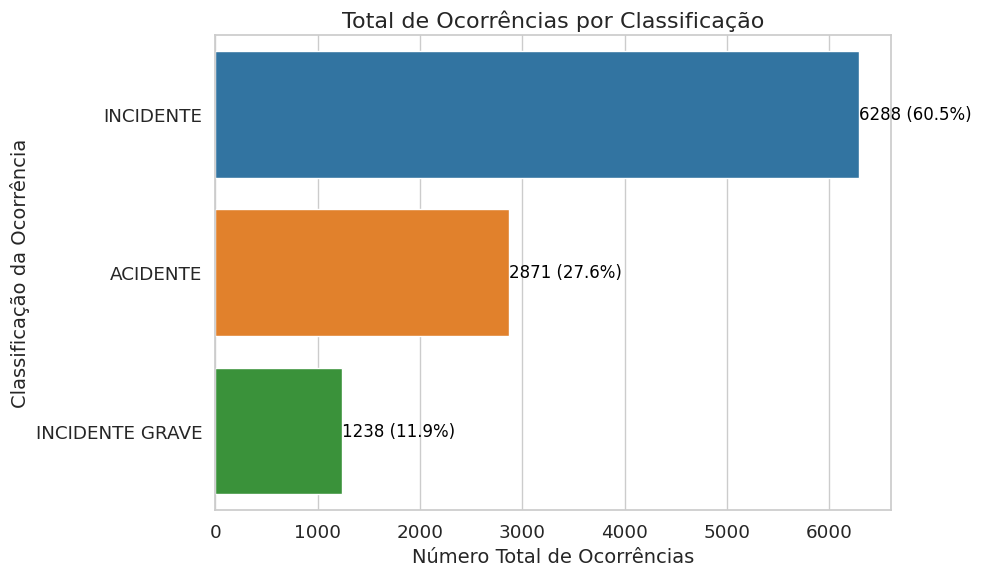

In [11]:
# Contar as ocorrências por classificação
totais = df['Classificação da ocorrência'].value_counts().reset_index()
totais.columns = ['Classificação da ocorrência', 'Total']

# Calcular porcentagens
totais['Porcentagem'] = (totais['Total'] / totais['Total'].sum()) * 100

# Configurações do gráfico
plt.figure(figsize=(10, 6))
sbn.set(font_scale=1.2)
sbn.set_style('whitegrid')

# Gráfico de barras horizontais
ax = sbn.barplot(
    data=totais,
    x='Total',
    y='Classificação da ocorrência',
    palette=['#1f77b4', '#ff7f0e', '#2ca02c']  # Paleta de cores personalizadas
)

# Adicionar rótulos de dados com números e porcentagens
for index, row in totais.iterrows():
    ax.text(
        row['Total'] + 0.5, index,  # Posição do rótulo
        f"{row['Total']} ({row['Porcentagem']:.1f}%)",  # Texto do rótulo
        color='black', va='center', fontsize=12
    )

# Personalização dos eixos e título
plt.title('Total de Ocorrências por Classificação', fontsize=16)
plt.xlabel('Número Total de Ocorrências', fontsize=14)
plt.ylabel('Classificação da Ocorrência', fontsize=14)
plt.tight_layout()

# Exibir o gráfico
plt.show()

In [19]:
import pandas as pd
import folium
import numpy as np

# Extrair latitudes e longitudes
latitudes = df['Latitude da ocorrência'].tolist()
longitudes = df['Longitude da ocorrência'].tolist()

# Criar uma coluna que representa a contagem de ocorrências por latitude e longitude
df['Ocorrências'] = df.groupby(['Latitude da ocorrência', 'Longitude da ocorrência'])['Latitude da ocorrência'].transform('count')

# Filtrar para mostrar apenas locais com mais de 10 ocorrências
df_ocorrencias_filtrado = df[df['Ocorrências'] > 10]

# Criar o mapa centralizado na média das coordenadas com zoom ajustado
mapa = folium.Map(location=[
    df_ocorrencias_filtrado['Latitude da ocorrência'].mean(),
    df_ocorrencias_filtrado['Longitude da ocorrência'].mean()
], zoom_start=5)

# Adicionar marcadores ao mapa
for index, row in df_ocorrencias_filtrado.iterrows():
    folium.CircleMarker(
        location=[row['Latitude da ocorrência'], row['Longitude da ocorrência']],
        radius=max(row['Ocorrências'] / 10, 3),  # Reduzir e limitar o tamanho mínimo
        popup=f"Ocorrências: {row['Ocorrências']}",
        color='red' if row['Ocorrências'] > 100 else 'blue',  # Destacar locais críticos
        fill=True,
        fill_color='red' if row['Ocorrências'] > 100 else 'blue'
    ).add_to(mapa)

# Salvar o mapa como arquivo HTML
mapa.save('mapa_ocorrencias.html')

# Mensagem de conclusão
print("Mapa criado e salvo como 'mapa_ocorrencias.html'. Abra o arquivo no navegador para visualizar.")

from google.colab import files
# Baixar o arquivo HTML
files.download('mapa_ocorrencias.html')





Mapa criado e salvo como 'mapa_ocorrencias.html'. Abra o arquivo no navegador para visualizar.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

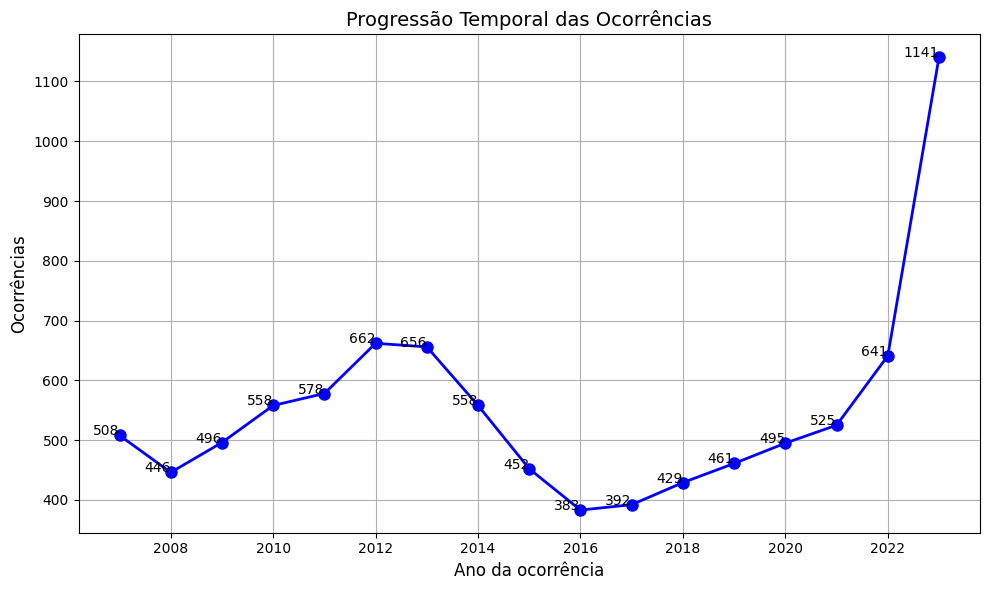

In [22]:
# Contando o número de ocorrências por ano
df_grouped = df.groupby('Ano da ocorrência').size().reset_index(name='Ocorrências')

# Plotando o gráfico
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['Ano da ocorrência'], df_grouped['Ocorrências'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Adicionando título e rótulos aos eixos
plt.title('Progressão Temporal das Ocorrências', fontsize=14)
plt.xlabel('Ano da ocorrência', fontsize=12)
plt.ylabel('Ocorrências', fontsize=12)

# Exibindo as labels para cada ponto
for i, txt in enumerate(df_grouped['Ocorrências']):
    plt.text(df_grouped['Ano da ocorrência'].iloc[i], df_grouped['Ocorrências'].iloc[i], str(txt), fontsize=10, ha='right')

# Exibindo o gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

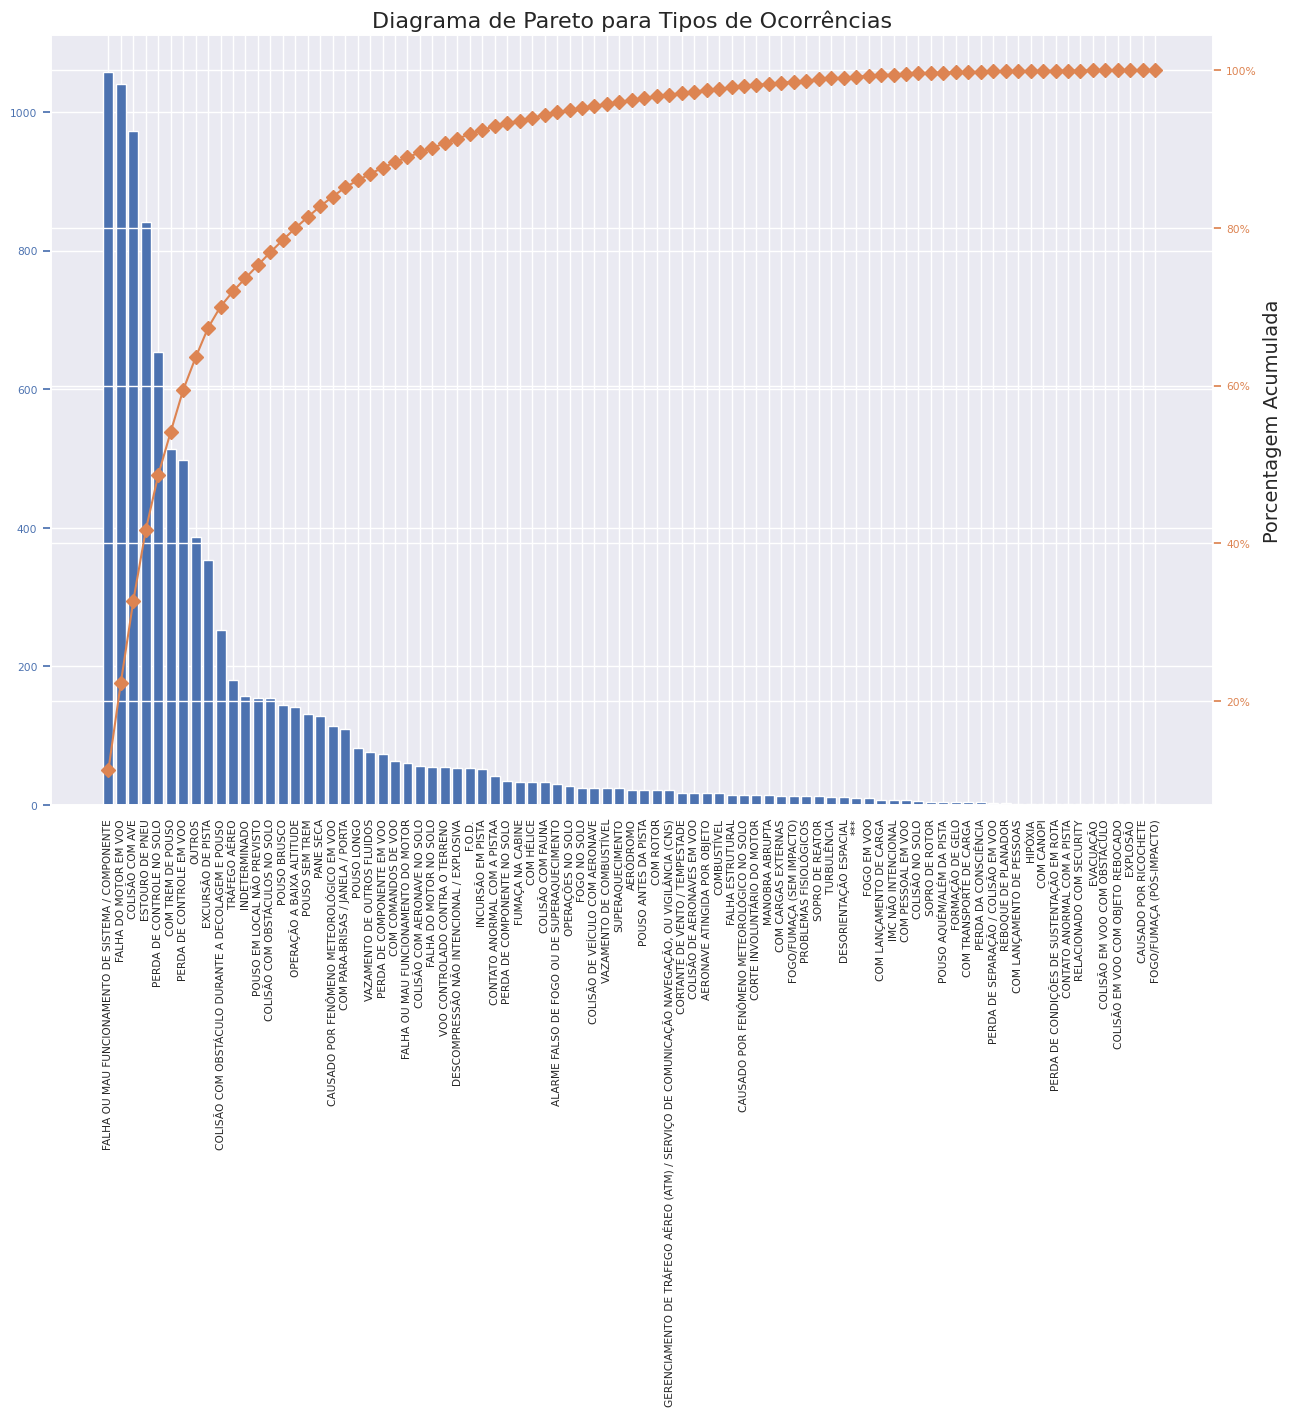

In [26]:
# Ajustar a escala da fonte do gráfico
sbn.set(font_scale=0.7)

#Agrupar e contar ocorrências por tipo de ocorrência
oc_tipo = df.groupby('Tipo de ocorrência').size().reset_index(name='Número de Ocorrências')

# Passo 2: Ordenar os tipos de ocorrência por número de ocorrências
oc_tipo = oc_tipo.sort_values(by='Número de Ocorrências', ascending=False)

# Passo 3: Calcular a porcentagem acumulada
oc_tipo["Porcentagem Acumulada"] = oc_tipo['Número de Ocorrências'].cumsum() / oc_tipo['Número de Ocorrências'].sum() * 100

# Passo 4: Criar o gráfico de Pareto
fig, ax = plt.subplots(figsize=(15, 10))

# Barras para o número de ocorrências
ax.bar(oc_tipo['Tipo de ocorrência'], oc_tipo['Número de Ocorrências'], color="C0")

# Eixo y secundário para a linha de porcentagem acumulada
ax2 = ax.twinx()  # Criar um segundo eixo y para a linha de porcentagem
ax2.plot(oc_tipo['Tipo de ocorrência'], oc_tipo["Porcentagem Acumulada"], color="C1", marker="D", ms=7)

# Formatador para o eixo y da porcentagem
ax2.yaxis.set_major_formatter(PercentFormatter())

# Rótulos dos eixos
plt.title('Diagrama de Pareto para Tipos de Ocorrências', fontsize=16)
plt.xlabel('Tipo de Ocorrência', fontsize=14)
plt.ylabel('Número de Ocorrências', fontsize=14)
ax2.set_ylabel('Porcentagem Acumulada', fontsize=14)

# Ajustar a rotação dos rótulos do eixo X para facilitar a leitura
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

# Ajustar os eixos
ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

# Exibir o gráfico
plt.show()


Tabela 5 - Principais Tipos de Ocorrências
                                   Tipo de ocorrência  Número de Ocorrências  \
43  FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...                   1058   
40                              FALHA DO MOTOR EM VOO                   1040   
8                                     COLISÃO COM AVE                    973   
35                                    ESTOURO DE PNEU                    841   
66                          PERDA DE CONTROLE NO SOLO                    654   
..                                                ...                    ...   
15                       COLISÃO EM VOO COM OBSTÁCULO                      1   
14                 COLISÃO EM VOO COM OBJETO REBOCADO                      1   
38                                           EXPLOSÃO                      1   
6                               CAUSADO POR RICOCHETE                      1   
47                          FOGO/FUMAÇA (PÓS-IMPACTO)                      1 

Outliers encontrados:
 Empty DataFrame
Columns: [Código da ocorrência, Classificação da ocorrência, Latitude da ocorrência, Longitude da ocorrência, Código IBGE do município, Nome do município, Código IBGE da microrregião, Nome da microrregiao, Código IBGE da mesoregião, Nome da mesoregião, Código IBGE da UF, Sigla UF, Unidade federativa, Código IBGE da região, Sigla da região, Região, País da ocorrência, Aeródromo da ocorrência, Dia da ocorrência, Ano da ocorrência, Hora da ocorrência, Data e hora da ocorrência, Aeronave liberada da investigação, Status da investigação, Número de divulgação do relatório, Divulgação do relatório publicado, Dia de divulgação da publicação, Total de recomendações, Total de aeronaves envolvidas, Ocorrência de saída da pista, Matrícula da aeronave, Categoria do operador da aeronave, Tipo de veículo, Fabricante da aeronave, Modelo da aeronave, Tipo de operação da aeronave, Tipo de icao da aeronave, Tipo de motor da aeronave, Quantidade de motores da aeronav

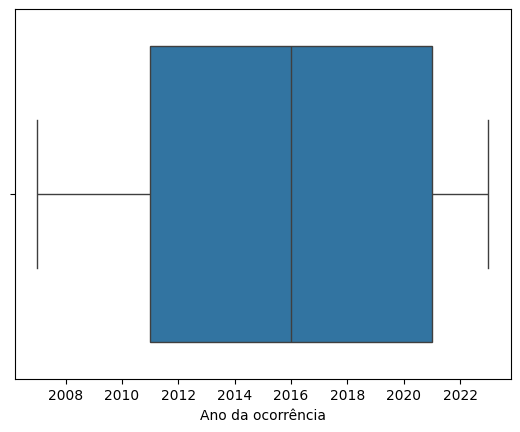

In [9]:
# Identificar outliers com o método do IQR
Q1 = df['Ano da ocorrência'].quantile(0.25)
Q3 = df['Ano da ocorrência'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['Ano da ocorrência'] < limite_inferior) | (df['Ano da ocorrência'] > limite_superior)]
print("Outliers encontrados:\n", outliers)

# Boxplot para visualizar outliers
sbn.boxplot(x=df['Ano da ocorrência'])
plt.show()

# Remover outliers
df = df[~((df['Ano da ocorrência'] < limite_inferior) | (df['Ano da ocorrência'] > limite_superior))]

Outliers encontrados:
        Código da ocorrência Classificação da ocorrência  \
3                     38855                    ACIDENTE   
4                     50831                    ACIDENTE   
11                    52838                    ACIDENTE   
19                    46437                    ACIDENTE   
37                    46916                    ACIDENTE   
...                     ...                         ...   
10274                 46710                    ACIDENTE   
10278                 81852                    ACIDENTE   
10283                 53579                    ACIDENTE   
10292                 78717                    ACIDENTE   
10382                 37357                    ACIDENTE   

       Latitude da ocorrência  Longitude da ocorrência  \
3                  -31.867518               -54.163801   
4                  -17.400018               -50.379307   
11                 -14.053066               -52.164185   
19                 -20.448000       

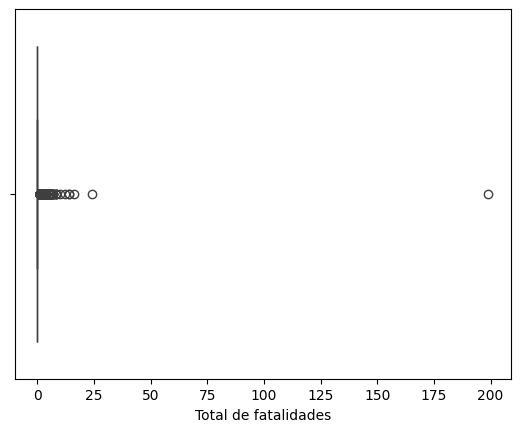

In [ ]:
# Identificar outliers com o método do IQR
Q1 = df['Total de fatalidades'].quantile(0.25)
Q3 = df['Total de fatalidades'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['Total de fatalidades'] < limite_inferior) | (df['Total de fatalidades'] > limite_superior)]
print("Outliers encontrados:\n", outliers)

# Boxplot para visualizar outliers
sbn.boxplot(x=df['Total de fatalidades'])
plt.show()

# Remover outliers
df = df[~((df['Total de fatalidades'] < limite_inferior) | (df['Total de fatalidades'] > limite_superior))]

Outliers encontrados:
        Código da ocorrência Classificação da ocorrência  \
0                     78640                    ACIDENTE   
13                    80333                   INCIDENTE   
29                    77731                    ACIDENTE   
33                    45913                    ACIDENTE   
43                    66522                    ACIDENTE   
...                     ...                         ...   
10342                 45943                   INCIDENTE   
10348                 81043                   INCIDENTE   
10359                 81116                   INCIDENTE   
10360                 81116                   INCIDENTE   
10396                 43729                    ACIDENTE   

       Latitude da ocorrência  Longitude da ocorrência  \
0                  -16.762062               -49.438403   
13                 -14.053066               -52.164185   
29                 -29.645000               -53.240000   
33                  -2.406669       

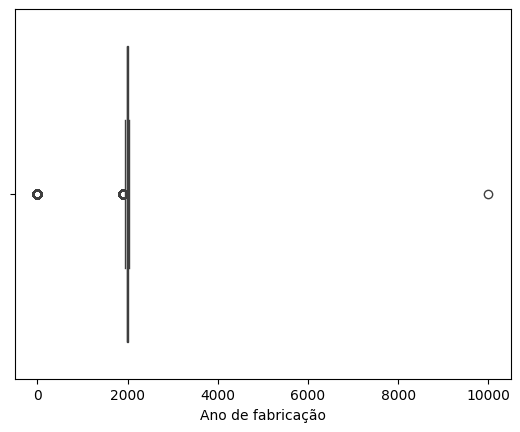

In [20]:
# Identificar outliers com o método do IQR
Q1 = df['Ano de fabricação'].quantile(0.25)
Q3 = df['Ano de fabricação'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['Ano de fabricação'] < limite_inferior) | (df['Ano de fabricação'] > limite_superior)]
print("Outliers encontrados:\n", outliers)

# Boxplot para visualizar outliers
sbn.boxplot(x=df['Ano de fabricação'])
plt.show()

# Remover outliers
df = df[~((df['Ano de fabricação'] < limite_inferior) | (df['Ano de fabricação'] > limite_superior))]

Outliers encontrados:
        Código da ocorrência Classificação da ocorrência  \
27                    49474                    ACIDENTE   
28                    36604                   INCIDENTE   
49                    48757                   INCIDENTE   
60                    44917                   INCIDENTE   
77                    43899                    ACIDENTE   
...                     ...                         ...   
10383                 82604                   INCIDENTE   
10384                 77641                   INCIDENTE   
10385                 42386                    ACIDENTE   
10386                 42386                    ACIDENTE   
10387                 53004                   INCIDENTE   

       Latitude da ocorrência  Longitude da ocorrência  \
27                   0.000000                 0.000000   
28                   0.000000                 0.000000   
49                 -20.637309               -40.748830   
60                  -9.871723       

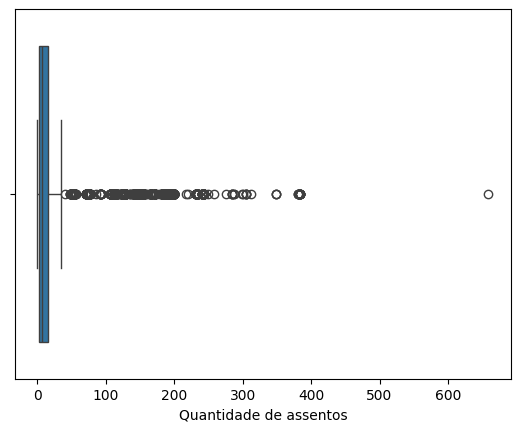

In [ ]:
# Identificar outliers com o método do IQR
Q1 = df['Quantidade de assentos'].quantile(0.25)
Q3 = df['Quantidade de assentos'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['Quantidade de assentos'] < limite_inferior) | (df['Quantidade de assentos'] > limite_superior)]
print("Outliers encontrados:\n", outliers)

# Boxplot para visualizar outliers
sbn.boxplot(x=df['Quantidade de assentos'])
plt.show()

# Remover outliers
df = df[~((df['Quantidade de assentos'] < limite_inferior) | (df['Quantidade de assentos'] > limite_superior))]

Outliers encontrados:
        Código da ocorrência Classificação da ocorrência  \
142                   61014             INCIDENTE GRAVE   
146                   61014             INCIDENTE GRAVE   
159                   47245                   INCIDENTE   
163                   47245                   INCIDENTE   
180                   51433                    ACIDENTE   
...                     ...                         ...   
10009                 52614                   INCIDENTE   
10293                 77832                   INCIDENTE   
10302                 77832                   INCIDENTE   
10355                 81116                   INCIDENTE   
10357                 81116                   INCIDENTE   

       Latitude da ocorrência  Longitude da ocorrência  \
142                  3.652152               -61.419385   
146                  3.652152               -61.419385   
159                -22.739000               -47.331000   
163                -22.739000       

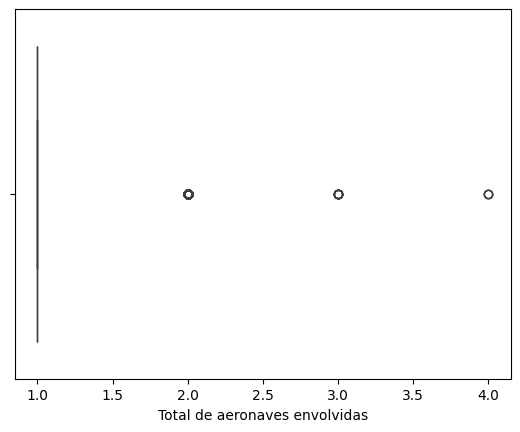

In [ ]:
# Identificar outliers com o método do IQR
Q1 = df['Total de aeronaves envolvidas'].quantile(0.25)
Q3 = df['Total de aeronaves envolvidas'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['Total de aeronaves envolvidas'] < limite_inferior) | (df['Total de aeronaves envolvidas'] > limite_superior)]
print("Outliers encontrados:\n", outliers)

# Boxplot para visualizar outliers
sbn.boxplot(x=df['Total de aeronaves envolvidas'])
plt.show()

# Remover outliers
df = df[~((df['Total de aeronaves envolvidas'] < limite_inferior) | (df['Total de aeronaves envolvidas'] > limite_superior))]

Outliers encontrados:
        Código da ocorrência Classificação da ocorrência  \
9                     42071                    ACIDENTE   
14                    79131                    ACIDENTE   
18                    36097             INCIDENTE GRAVE   
23                    44464                    ACIDENTE   
24                    53628                    ACIDENTE   
...                     ...                         ...   
10273                 77653                    ACIDENTE   
10279                 79231                    ACIDENTE   
10287                 80311                    ACIDENTE   
10296                 43998             INCIDENTE GRAVE   
10393                 80238             INCIDENTE GRAVE   

       Latitude da ocorrência  Longitude da ocorrência  \
9                   -0.157282               -50.390247   
14                 -14.053066               -52.164185   
18                  -5.891845               -42.634111   
23                 -20.448000       

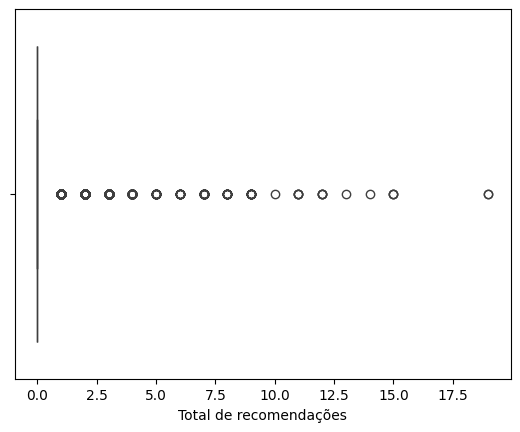

In [ ]:
# Identificar outliers com o método do IQR
Q1 = df['Total de recomendações'].quantile(0.25)
Q3 = df['Total de recomendações'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['Total de recomendações'] < limite_inferior) | (df['Total de recomendações'] > limite_superior)]
print("Outliers encontrados:\n", outliers)

# Boxplot para visualizar outliers
sbn.boxplot(x=df['Total de recomendações'])
plt.show()

# Remover outliers
df = df[~((df['Total de recomendações'] < limite_inferior) | (df['Total de recomendações'] > limite_superior))]

Outliers encontrados:
 Empty DataFrame
Columns: [Código da ocorrência, Classificação da ocorrência, Latitude da ocorrência, Longitude da ocorrência, Código IBGE do município, Nome do município, Código IBGE da microrregião, Nome da microrregiao, Código IBGE da mesoregião, Nome da mesoregião, Código IBGE da UF, Sigla UF, Unidade federativa, Código IBGE da região, Sigla da região, Região, País da ocorrência, Aeródromo da ocorrência, Dia da ocorrência, Ano da ocorrência, Hora da ocorrência, Data e hora da ocorrência, Aeronave liberada da investigação, Status da investigação, Número de divulgação do relatório, Divulgação do relatório publicado, Dia de divulgação da publicação, Total de recomendações, Total de aeronaves envolvidas, Ocorrência de saída da pista, Matrícula da aeronave, Categoria do operador da aeronave, Tipo de veículo, Fabricante da aeronave, Modelo da aeronave, Tipo de operação da aeronave, Tipo de icao da aeronave, Tipo de motor da aeronave, Quantidade de motores da aeronav

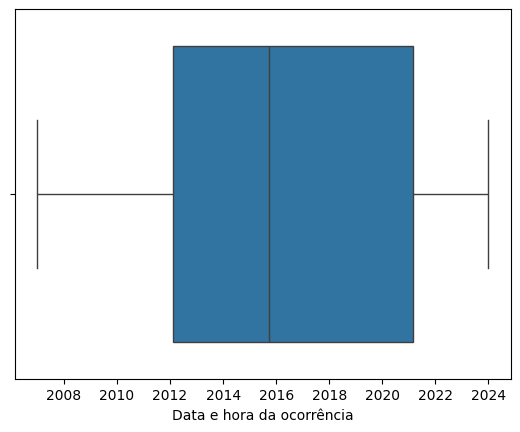

In [ ]:
# Identificar outliers com o método do IQR
Q1 = df['Data e hora da ocorrência'].quantile(0.25)
Q3 = df['Data e hora da ocorrência'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['Data e hora da ocorrência'] < limite_inferior) | (df['Data e hora da ocorrência'] > limite_superior)]
print("Outliers encontrados:\n", outliers)

# Boxplot para visualizar outliers
sbn.boxplot(x=df['Data e hora da ocorrência'])
plt.show()

# Remover outliers
df = df[~((df['Data e hora da ocorrência'] < limite_inferior) | (df['Data e hora da ocorrência'] > limite_superior))]

Tabela de Contingência:
Classificação da ocorrência      ACIDENTE  INCIDENTE  INCIDENTE GRAVE
Fase de operação                                                     
APROXIMAÇÃO FINAL                      50        207               25
ARREMETIDA NO AR                        8         14                5
ARREMETIDA NO SOLO                     13         25               13
CHEQUE DE MOTOR OU ROTOR                0         11                0
CIRCUITO DE TRÁFEGO                    29         78                8
CORRIDA APÓS POUSO                    139        483              183
CRUZEIRO                              156        446               97
DECOLAGEM                             242        474              123
DECOLAGEM VERTICAL                      3          7                1
DESCIDA                                14        102               12
DESCIDA DE EMERGÊNCIA                   1          0                1
EMPREGO MILITAR                         0          1              

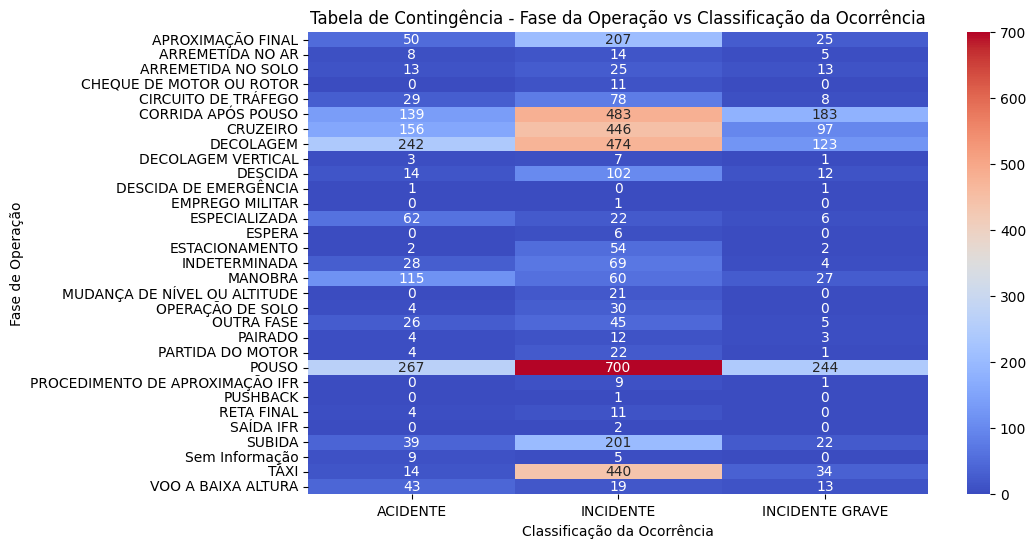

In [ ]:
from scipy.stats import chi2_contingency
# Criar a tabela de contingência
tabela_contingencia = pd.crosstab(df['Fase de operação'], df['Classificação da ocorrência'])
# Exibir a tabela de contingência
print("Tabela de Contingência:")
print(tabela_contingencia)

# Realizar o teste qui-quadrado
chi2, p_valor, dof, esperados = chi2_contingency(tabela_contingencia)

# Exibir os resultados
print("\nResultados do Teste Qui-Quadrado:")
print(f"Qui-quadrado: {chi2}")
print(f"Valor p: {p_valor}")
print(f"Graus de liberdade: {dof}")
print("Tabela Esperada:")
print(pd.DataFrame(esperados, columns=tabela_contingencia.columns, index=tabela_contingencia.index))

# Interpretação do valor p
if p_valor < 0.05:
    print("\nRejeitamos a hipótese nula. Existe uma associação significativa entre a Fase da Operação e a Classificação da Ocorrência.")
else:
    print("\nNão rejeitamos a hipótese nula. Não há associação significativa entre a Fase da Operação e a Classificação da Ocorrência.")

# Visualização com heatmap
plt.figure(figsize=(10, 6))
sbn.heatmap(tabela_contingencia, annot=True, fmt='d', cmap='coolwarm', cbar=True)
plt.title('Tabela de Contingência - Fase da Operação vs Classificação da Ocorrência')
plt.xlabel('Classificação da Ocorrência')
plt.ylabel('Fase de Operação')
plt.show()

Tabela de Contingência:
Tipo de veículo                  ANFÍBIO  AVIÃO  BALÃO  GIROCÓPTERO  \
Fase de operação                                                      
APROXIMAÇÃO FINAL                      0    197      0            0   
ARREMETIDA NO AR                       0     20      0            0   
ARREMETIDA NO SOLO                     0     49      0            0   
CHEQUE DE MOTOR OU ROTOR               0      7      0            0   
CIRCUITO DE TRÁFEGO                    0     85      0            0   
CORRIDA APÓS POUSO                     5    765      0            0   
CRUZEIRO                               0    461      1            0   
DECOLAGEM                              0    715      0            0   
DECOLAGEM VERTICAL                     0      0      0            0   
DESCIDA                                0    106      0            0   
DESCIDA DE EMERGÊNCIA                  0      0      0            0   
EMPREGO MILITAR                        0      0      

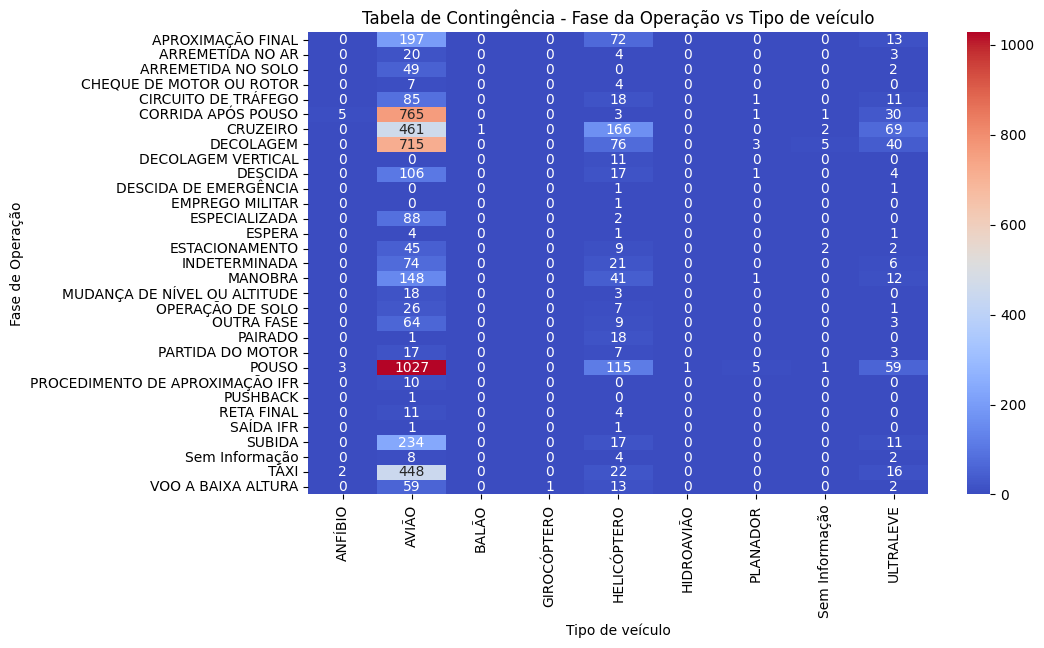

In [ ]:
# Criar a tabela de contingência
tabela_contingencia = pd.crosstab(df['Fase de operação'], df['Tipo de veículo'])
# Exibir a tabela de contingência
print("Tabela de Contingência:")
print(tabela_contingencia)

# Realizar o teste qui-quadrado
chi2, p_valor, dof, esperados = chi2_contingency(tabela_contingencia)

# Exibir os resultados
print("\nResultados do Teste Qui-Quadrado:")
print(f"Qui-quadrado: {chi2}")
print(f"Valor p: {p_valor}")
print(f"Graus de liberdade: {dof}")
print("Tabela Esperada:")
print(pd.DataFrame(esperados, columns=tabela_contingencia.columns, index=tabela_contingencia.index))

# Interpretação do valor p
if p_valor < 0.05:
    print("\nRejeitamos a hipótese nula. Existe uma associação significativa entre a Fase da Operação e a Tipo de veículo.")
else:
    print("\nNão rejeitamos a hipótese nula. Não há associação significativa entre a Fase da Operação e a Tipo de veículo.")

# Visualização com heatmap
plt.figure(figsize=(10, 6))
sbn.heatmap(tabela_contingencia, annot=True, fmt='d', cmap='coolwarm', cbar=True)
plt.title('Tabela de Contingência - Fase da Operação vs Tipo de veículo')
plt.xlabel('Tipo de veículo')
plt.ylabel('Fase de Operação')
plt.show()

Tabela de Contingência:
Tipo de veículo              ANFÍBIO  AVIÃO  BALÃO  GIROCÓPTERO  HELICÓPTERO  \
Classificação da ocorrência                                                    
ACIDENTE                           0    982      1            1          124   
INCIDENTE                          8   2989      0            0          504   
INCIDENTE GRAVE                    2    718      0            0           39   

Tipo de veículo              HIDROAVIÃO  PLANADOR  Sem Informação  ULTRALEVE  
Classificação da ocorrência                                                   
ACIDENTE                              0         3               2        163  
INCIDENTE                             1         8               8         59  
INCIDENTE GRAVE                       0         1               1         69  

Resultados do Teste Qui-Quadrado:
Qui-quadrado: 321.1280002106823
Valor p: 1.0574968086269952e-58
Graus de liberdade: 16
Tabela Esperada:
Tipo de veículo               ANFÍBIO    

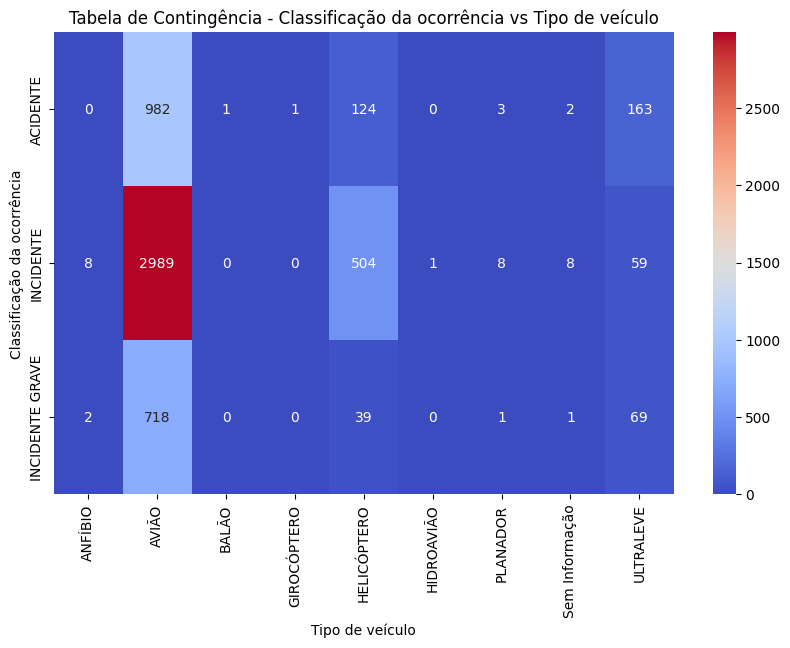

In [ ]:
# Criar a tabela de contingência
tabela_contingencia = pd.crosstab(df['Classificação da ocorrência'], df['Tipo de veículo'])
# Exibir a tabela de contingência
print("Tabela de Contingência:")
print(tabela_contingencia)

# Realizar o teste qui-quadrado
chi2, p_valor, dof, esperados = chi2_contingency(tabela_contingencia)

# Exibir os resultados
print("\nResultados do Teste Qui-Quadrado:")
print(f"Qui-quadrado: {chi2}")
print(f"Valor p: {p_valor}")
print(f"Graus de liberdade: {dof}")
print("Tabela Esperada:")
print(pd.DataFrame(esperados, columns=tabela_contingencia.columns, index=tabela_contingencia.index))

# Interpretação do valor p
if p_valor < 0.05:
    print("\nRejeitamos a hipótese nula. Existe uma associação significativa entre a Classificação da ocorrência e a Tipo de veículo.")
else:
    print("\nNão rejeitamos a hipótese nula. Não há associação significativa entre a Classificação da ocorrência e a Tipo de veículo.")

# Visualização com heatmap
plt.figure(figsize=(10, 6))
sbn.heatmap(tabela_contingencia, annot=True, fmt='d', cmap='coolwarm', cbar=True)
plt.title('Tabela de Contingência - Classificação da ocorrência vs Tipo de veículo')
plt.xlabel('Tipo de veículo')
plt.ylabel('Classificação da ocorrência')
plt.show()